## Week 10

In [1]:
# Samuel Harris
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import numpy as np

In [2]:
df = pd.read_csv('/Users/samharris/Desktop/Capstone/24Spr_-S-Harris-_-disasters-/Sample_Capstone/data/em_dat_since2000_and_w_bank.csv')
print(df.shape)
df.head()

(15573, 44)


,DisNo.,Classification Key,Disaster Group,Disaster Subgroup,Disaster Type,Disaster Subtype,Event Name,ISO,Country,Subregion,...,i_mort,co2_emissions,electricity_percentage,life_expectancy,mv_gdp,mv_imort,mv_electy,mv_pop_den,mv_co2,mv_lf_exp
0,1999-9388-DJI,nat-cli-dro-dro,Natural,Climatological,Drought,Drought,NaN,DJI,Djibouti,Sub-Saharan Africa,...,78.0,0.491842,56.119118,56.903,2.0,10.0,3.0,3.0,3.0,1.0
1,1999-9388-SDN,nat-cli-dro-dro,Natural,Climatological,Drought,Drought,NaN,SDN,Sudan,Northern Africa,...,67.0,0.216388,23.000000,58.319,1.0,9.0,1.0,1.0,2.0,2.0
2,1999-9388-SOM,nat-cli-dro-dro,Natural,Climatological,Drought,Drought,NaN,SOM,Somalia,Sub-Saharan Africa,...,104.5,0.055793,2.109354,50.660,NaN,10.0,1.0,1.0,1.0,1.0
3,2000-0001-AGO,tec-tra-roa-roa,Technological,Transport,Road,Road,NaN,AGO,Angola,Sub-Saharan Africa,...,121.9,0.988416,24.238865,46.024,1.0,10.0,1.0,1.0,4.0,1.0
4,2000-0002-AGO,nat-hyd-flo-riv,Natural,Hydrological,Flood,Riverine flood,NaN,AGO,Angola,Sub-Saharan Africa,...,121.9,0.988416,24.238865,46.024,1.0,10.0,1.0,1.0,4.0,1.0


### Risk Score

In [3]:
country_result = df.groupby(['Country', 'ISO'])['Disaster Type'].value_counts()
result_df = country_result.reset_index(name='count')

# Group the counts by disaster type
counts_by_disaster_type = result_df.groupby('Disaster Type')['count'].sum()


# Calculate the relative frequency for each disaster type
result_df['relative_frequency'] = result_df.apply(lambda row: row['count'] / counts_by_disaster_type[row['Disaster Type']], axis=1)


# Calculate the scaling factor for each disaster type
max_relative_frequency_by_disaster_type = result_df.groupby('Disaster Type')['relative_frequency'].max()
scaling_factors = 100 / max_relative_frequency_by_disaster_type

# Scale the relative frequency for each disaster type
result_df['scaled_relative_frequency'] = result_df.apply(lambda row: row['relative_frequency'] * scaling_factors[row['Disaster Type']], axis=1)

In [4]:
result_df2 = df.groupby(['Country', 'ISO', 'Disaster Type'])[['Total Deaths', 'Total Affected']].sum()
result_df2 = result_df2.reset_index()

result_df2['scaled_deaths'] = result_df2['Total Deaths'].clip(upper=20000)

result_df2['scaled_affected'] = result_df2['Total Affected'].clip(upper=100000)

result_df2['scaled_deaths'] = result_df2['scaled_deaths']/200
result_df2['scaled_affected'] = result_df2['scaled_affected']/1000

result_df2['Impact'] = result_df2['scaled_deaths']*.75 + result_df2['scaled_affected']*.25

result_df2

,Country,ISO,Disaster Type,Total Deaths,Total Affected,scaled_deaths,scaled_affected,Impact
0,Afghanistan,AFG,Air,290.0,26.0,1.450,0.026,1.09400
1,Afghanistan,AFG,Collapse (Industrial),50.0,35.0,0.250,0.035,0.19625
2,Afghanistan,AFG,Collapse (Miscellaneous),111.0,1055.0,0.555,1.055,0.68000
3,Afghanistan,AFG,Drought,37.0,31010000.0,0.185,100.000,25.13875
4,Afghanistan,AFG,Earthquake,4523.0,827029.0,22.615,100.000,41.96125
...,...,...,...,...,...,...,...,...
1869,Zimbabwe,ZWE,Miscellaneous accident (General),38.0,300.0,0.190,0.300,0.21750
1870,Zimbabwe,ZWE,Rail,65.0,84.0,0.325,0.084,0.26475
1871,Zimbabwe,ZWE,Road,663.0,745.0,3.315,0.745,2.67250
1872,Zimbabwe,ZWE,Storm,933.0,391084.0,4.665,100.000,28.49875


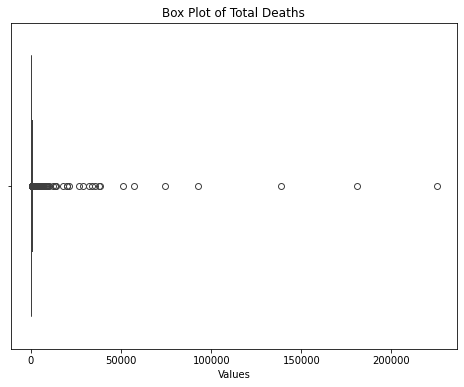

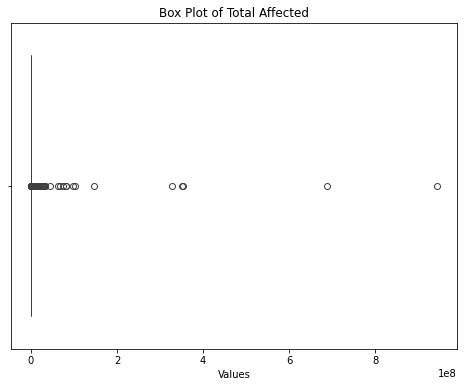

In [5]:
# Select the column for which you want to create a box plot
column_name = 'Total Deaths'

# Plot box plot for the selected column
plt.figure(figsize=(8, 6))  # Set the size of the plot
sns.boxplot(x=result_df2[column_name])
plt.title(f'Box Plot of {column_name}')
plt.xlabel('Values')
plt.show()

column_name = 'Total Affected'
# Plot box plot for the selected column
plt.figure(figsize=(8, 6))  # Set the size of the plot
sns.boxplot(x=result_df2[column_name])
plt.title(f'Box Plot of {column_name}')
plt.xlabel('Values')
plt.show()


def flip_imort(value):
    # Define the mapping
    mapping = {10: 1, 9: 2, 8: 3, 7: 4, 6: 5, 5: 6, 4: 7, 3: 8, 2:9, 1:10 }  # Add more mappings as needed

    # Check if the value is in the mapping, otherwise return the value
    return mapping.get(value, value)

# Apply the custom function to flip the values and create a new column
df['flipped_mv_imort'] = df['mv_imort'].apply(flip_imort)

result_df3 = df.groupby(['Country', 'ISO', 'Disaster Type'])[['mv_gdp', 'mv_electy', 'mv_co2', 'mv_lf_exp', 'flipped_mv_imort']].mean()
result_df3 = result_df3.reset_index()
#result_df3.fillna(1, inplace=True)


result_df3['lack_of_resilence'] = (result_df3['mv_gdp'] + result_df3['mv_electy'] + result_df3['mv_co2'] + result_df3['mv_lf_exp']+ result_df3['flipped_mv_imort'])/(5/10)
print(result_df3['lack_of_resilence'].max(), result_df3['lack_of_resilence'].min())

## Transforming scale from low to high

for index, value in result_df3['lack_of_resilence'].items():
    if value == 55:
        result_df3['lack_of_resilence'][index] = value
    elif value > 55:
        result_df3['lack_of_resilence'][index] = 55 - (value - 55)
    else: 
        result_df3['lack_of_resilence'][index] = 55 + (55 - value)

In [6]:

def flip_imort(value):
    # Define the mapping
    mapping = {10: 1, 9: 2, 8: 3, 7: 4, 6: 5, 5: 6, 4: 7, 3: 8, 2:9, 1:10 }  # Add more mappings as needed

    # Check if the value is in the mapping, otherwise return the value
    return mapping.get(value, value)

# Apply the custom function to flip the values and create a new column
df['flipped_mv_imort'] = df['mv_imort'].apply(flip_imort)

result_df3 = df.groupby(['Country', 'ISO', 'Start Year'])[['mv_gdp', 'mv_electy', 'mv_co2', 'mv_lf_exp', 'flipped_mv_imort']].mean()
result_df3 = result_df3.groupby(['Country', 'ISO'])[['mv_gdp', 'mv_electy', 'mv_co2', 'mv_lf_exp', 'flipped_mv_imort']].mean()
result_df3 = result_df3.reset_index()
#result_df3.fillna(1, inplace=True)
def linear_scale(value, min_val, max_val):
    return ((value - min_val) / (max_val - min_val)) * 100

result_df3['lack_of_resilence'] = result_df3['mv_gdp'] + result_df3['mv_electy'] + result_df3['mv_co2'] + result_df3['mv_lf_exp']+ result_df3['flipped_mv_imort']

for index, value in result_df3['lack_of_resilence'].items():
    if value == 27.5:
        result_df3['lack_of_resilence'][index] = value
    elif value > 27.5:
        result_df3['lack_of_resilence'][index] = 27.5 - (value - 27.5)
    else: 
        result_df3['lack_of_resilence'][index] = 27.5 + (27.5 - value)


result_df3['lack_of_resilence_scaled'] = result_df3['lack_of_resilence'].apply(lambda x: linear_scale(x, 5, 50))

result_df3

/var/folders/lg/vpwp92v96rsbh9x3s5fyjd9w0000gn/T/ipykernel_34952/2521379827.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df3['lack_of_resilence'][index] = 27.5 + (27.5 - value)
/var/folders/lg/vpwp92v96rsbh9x3s5fyjd9w0000gn/T/ipykernel_34952/2521379827.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df3['lack_of_resilence'][index] = 27.5 - (value - 27.5)
/var/folders/lg/vpwp92v96rsbh9x3s5fyjd9w0000gn/T/ipykernel_34952/2521379827.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

,Country,ISO,mv_gdp,mv_electy,mv_co2,mv_lf_exp,flipped_mv_imort,lack_of_resilence,lack_of_resilence_scaled
0,Afghanistan,AFG,1.150000,2.772727,1.571429,2.000000,1.863636,45.642208,90.316017
1,Albania,ALB,5.000000,7.142857,4.538462,8.285714,7.142857,22.890110,39.755800
2,Algeria,DZA,4.681818,5.476190,6.350000,6.142857,4.809524,27.539610,50.088023
3,American Samoa,ASM,7.000000,NaN,NaN,NaN,NaN,NaN,NaN
4,Angola,AGO,3.590909,1.818182,3.619048,1.500000,1.590909,42.880952,84.179894
...,...,...,...,...,...,...,...,...,...
217,Viet Nam,VNM,3.000000,5.500000,4.571429,6.045455,5.772727,30.110390,55.800866
218,Wallis and Futuna Islands,WLF,NaN,NaN,NaN,NaN,NaN,NaN,NaN
219,Yemen,YEM,2.000000,2.727273,3.285714,3.272727,2.636364,41.077922,80.173160
220,Zambia,ZMB,2.363636,1.523810,1.900000,1.571429,2.333333,45.307792,89.572872


In [7]:
# Merge1
merged_df = pd.merge(result_df[['Country', 'ISO', 'Disaster Type', 'scaled_relative_frequency']], 
                     result_df2[['Country', 'ISO', 'Disaster Type', 'Impact']], 
                     on=['Country', 'ISO', 'Disaster Type'], 
                     how='inner')

# Merge2
final_merged_df = pd.merge(merged_df, 
                           result_df3[['Country', 'ISO','lack_of_resilence_scaled']], 
                           on=['Country', 'ISO'], 
                           how='inner')
final_merged_df

,Country,ISO,Disaster Type,scaled_relative_frequency,Impact,lack_of_resilence_scaled
0,Afghanistan,AFG,Flood,39.170507,38.25625,90.316017
1,Afghanistan,AFG,Earthquake,18.918919,41.96125,90.316017
2,Afghanistan,AFG,Mass movement (wet),37.500000,28.53250,90.316017
3,Afghanistan,AFG,Road,10.204082,2.33725,90.316017
4,Afghanistan,AFG,Epidemic,25.396825,38.21875,90.316017
...,...,...,...,...,...,...
1869,Zimbabwe,ZWE,Miscellaneous accident (General),10.000000,0.21750,86.120731
1870,Zimbabwe,ZWE,Rail,3.636364,0.26475,86.120731
1871,Zimbabwe,ZWE,Collapse (Industrial),3.225806,0.07525,86.120731
1872,Zimbabwe,ZWE,Industrial accident (General),1.515152,0.24375,86.120731


In [8]:

# Fit and transform 'Risk Score' column
final_merged_df['Risk Score'] = .25*final_merged_df['scaled_relative_frequency'] + .5*final_merged_df['Impact'] +  .25*final_merged_df['lack_of_resilence_scaled']
#final_merged_df[['Risk Score']] = scaler.fit_transform(final_merged_df[['Risk Score']])

# Display the normalized DataFrame
final_merged_df.sort_values(by='Risk Score', ascending=False).head(20)

,Country,ISO,Disaster Type,scaled_relative_frequency,Impact,lack_of_resilence_scaled,Risk Score
722,India,IND,Flood,89.400922,100.00000,73.146371,90.636823
447,Democratic Republic of the Congo,COD,Epidemic,100.000000,76.26625,98.691260,87.805940
1505,Somalia,SOM,Drought,40.000000,100.00000,98.787879,84.696970
319,China,CHN,Earthquake,100.000000,100.00000,36.176046,84.044012
747,Indonesia,IDN,Earthquake,69.369369,100.00000,63.041178,83.102637
1288,Philippines,PHL,Storm,52.421652,100.00000,66.456490,79.719536
1173,Nigeria,NGA,Epidemic,76.190476,74.78875,87.400088,78.292016
1216,Pakistan,PAK,Earthquake,16.216216,100.00000,81.448857,74.416268
694,Haiti,HTI,Earthquake,3.603604,100.00000,87.031600,72.658801
768,Iran (Islamic Republic of),IRN,Earthquake,49.549550,100.00000,40.029697,72.394812


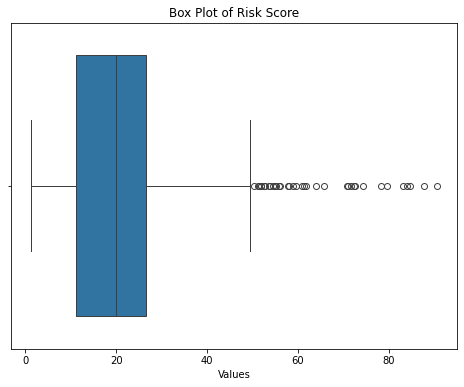

In [9]:
# Select the column for which you want to create a box plot
column_name = 'Risk Score'

# Plot box plot for the selected column
plt.figure(figsize=(8, 6))  # Set the size of the plot
sns.boxplot(x=final_merged_df[column_name])
plt.title(f'Box Plot of {column_name}')
plt.xlabel('Values')
plt.show()

In [10]:
# Define bins and labels
bins = [-float('inf'), 15, 25, 40, 55, float('inf')]
labels = ['Very Low', 'Low', 'Moderate', 'High', 'Very High']

# Add new column with bin labels
final_merged_df['Category'] = pd.cut(final_merged_df['Risk Score'], bins=bins, labels=labels, right=False)
final_merged_df

,Country,ISO,Disaster Type,scaled_relative_frequency,Impact,lack_of_resilence_scaled,Risk Score,Category
0,Afghanistan,AFG,Flood,39.170507,38.25625,90.316017,51.499756,High
1,Afghanistan,AFG,Earthquake,18.918919,41.96125,90.316017,48.289359,High
2,Afghanistan,AFG,Mass movement (wet),37.500000,28.53250,90.316017,46.220254,High
3,Afghanistan,AFG,Road,10.204082,2.33725,90.316017,26.298650,Moderate
4,Afghanistan,AFG,Epidemic,25.396825,38.21875,90.316017,48.037586,High
...,...,...,...,...,...,...,...,...
1869,Zimbabwe,ZWE,Miscellaneous accident (General),10.000000,0.21750,86.120731,24.138933,Low
1870,Zimbabwe,ZWE,Rail,3.636364,0.26475,86.120731,22.571649,Low
1871,Zimbabwe,ZWE,Collapse (Industrial),3.225806,0.07525,86.120731,22.374259,Low
1872,Zimbabwe,ZWE,Industrial accident (General),1.515152,0.24375,86.120731,22.030846,Low


In [11]:
import plotly.graph_objs as go
import pandas as pd
import os

# Group by ISO, Country and filter for rows with the maximum Risk Score within each group
top_scores = final_merged_df.dropna().groupby(['ISO', 'Country'])['Risk Score'].idxmax()
top_scores = final_merged_df.loc[top_scores]

# Define a mapping from categories to numerical values
category_mapping = {
    'Very Low': 1,
    'Low': 2,
    'Moderate': 3,
    'High': 4,
    'Very High': 5
}

# Map categories to numerical values
top_scores['Category Numerical'] = top_scores['Category'].map(category_mapping)

# Define colors for each category
category_colors = {
    'Very Low': 'rgb(173,216,230)',   # Light blue
    'Low': 'rgb(0,0,255)',             # Blue
    'Moderate': 'rgb(255, 255, 0)', # Yellow
    'High': 'rgb(255, 165, 0)', # Orange
    'Very High': 'rgb(255, 0, 0)'   # Red
}

# Create a Plotly choropleth map
fig = go.Figure(data=go.Choropleth(
    locations=top_scores['ISO'],  # ISO codes of countries
    z=top_scores['Category Numerical'],  # Numerical category values to be color-coded
    text=top_scores.apply(lambda row: f"Country: {row['Country']}<br>Risk Score: {round(row['Risk Score'], 2)}<br>Category: {row['Category']}<br>Disaster Type: {row['Disaster Type']}", axis=1),  # Text to display on hover including country, rounded risk score, category, and disaster type
    colorscale=[[i/(len(category_mapping)-1), category_colors[cat]] for i, cat in enumerate(category_mapping.keys())],
    autocolorscale=False,
    marker_line_color='darkgray',
    marker_line_width=0.5,
    colorbar_title='Risk Category',
    marker=dict(
        line=dict(color='rgb(180,180,180)', width=0.5),  # Specify marker line properties
    )
))

fig.update_layout(
    title_text='Risk Score by Country (Top Disaster Type From Each Country)',
    geo=dict(
        showcoastlines=True,  # Show coastlines
        landcolor='light grey'
    )
)
fig.add_annotation(
    x=1.19,  # X position of the annotation
    y=-0.1,  # Y position of the annotation
    text="No Data",  # Text of the annotation
    showarrow=False,  # Hide arrow
    font=dict(color="Black", size=12),  # Font color and size
    borderwidth=1,  # Border width of the annotation
    opacity=0.8,  # Opacity of the annotation
)
fig.update_layout(
    shapes=[
        dict(
            type="rect",
            xref="paper",
            yref="paper",
            x0=1.065,
            y0=-0.03,
            x1=1.031,
            y1=-.095,
            fillcolor="light grey",
            opacity=0.8,
            layer="below",
            line=dict(width=1),
        )
    ]
)
fig.show()

# Define the folder path where you want to save the HTML file
folder_path = "/Users/samharris/Desktop/Capstone/24Spr_-S-Harris-_-disasters-/Sample_Capstone/code/website/"

# Ensure that the folder exists
os.makedirs(folder_path, exist_ok=True)

# Define the file path
file_path = os.path.join(folder_path, 'risk_score_map.html')

# Save the figure as HTML file
fig.write_html(file_path)



In [12]:
import plotly.graph_objects as go
import plotly.io as pio


# Specify the full path where you want to save the image
file_path = "/Users/samharris/Desktop/"

# Specify the DPI (dots per inch) for higher resolution
dpi = 300

# Write the image using the kaleido engine with the desired DPI
#pio.write_image(fig, file_path + 'plot_high_dpi.png', engine='kaleido', scale=dpi/100)

In [51]:
final_merged_df.sort_values(by='Risk Score', ascending= False).head(20)

,Country,ISO,Disaster Type,scaled_relative_frequency,Impact,lack_of_resilence_scaled,Risk Score,Category
722,India,IND,Flood,89.400922,100.00000,73.146371,90.636823,Very High
447,Democratic Republic of the Congo,COD,Epidemic,100.000000,76.26625,98.691260,87.805940,Very High
1505,Somalia,SOM,Drought,40.000000,100.00000,98.787879,84.696970,Very High
319,China,CHN,Earthquake,100.000000,100.00000,36.176046,84.044012,Very High
747,Indonesia,IDN,Earthquake,69.369369,100.00000,63.041178,83.102637,Very High
1288,Philippines,PHL,Storm,52.421652,100.00000,66.456490,79.719536,Very High
1173,Nigeria,NGA,Epidemic,76.190476,74.78875,87.400088,78.292016,Very High
1216,Pakistan,PAK,Earthquake,16.216216,100.00000,81.448857,74.416268,Very High
694,Haiti,HTI,Earthquake,3.603604,100.00000,87.031600,72.658801,Very High
768,Iran (Islamic Republic of),IRN,Earthquake,49.549550,100.00000,40.029697,72.394812,Very High


## geo encoding

In [14]:
df_test = df.copy()

### Test

from geopy.geocoders import Nominatim

# Initialize Nominatim geocoder
geolocator = Nominatim(user_agent="my_geo")

# Example address (replace with your country, state, and province information)
address =  "Gaziantep, Turkey"

# Geocode the address
location = geolocator.geocode(address)

# Extract latitude and longitude
latitude = location.latitude
longitude = location.longitude

# Print latitude and longitude
print("Latitude:", latitude)
print("Longitude:", longitude)


Latitude: 37.0628317
Longitude: 37.3792617


In [15]:
def concatenate_country_location(row):
    location = row['Location']
    if isinstance(location, str):  # Check if 'Location' is a string and not NaN
        # Find the indices of the first comma and opening parentheses in the location string
        comma_idx = location.find(',')
        paren_idx = location.find('(')
        # Determine the stopping index (minimum of comma index and parenthesis index)
        stop_idx = min(comma_idx, paren_idx) if comma_idx != -1 and paren_idx != -1 else max(comma_idx, paren_idx)
        if stop_idx != -1:
            # If a comma or parentheses is found, discard everything after it
            first_location_part = location[:stop_idx].strip()
        else:
            # If neither a comma nor parentheses is found, use the entire location string
            first_location_part = location.strip()
            
        # Remove specified words from the first part of the location
        words_to_remove = ['area', 'provinces', 'province', 'village']
        first_location_part_words = first_location_part.split()
        first_location_part_words = [word for word in first_location_part_words if word.lower() not in words_to_remove]
        first_location_part = ' '.join(first_location_part_words)
        
        # Remove 'and' and anything after it if it appears in the first part of the location
        if 'and' in first_location_part:
            first_location_part = first_location_part.split('and')[0].strip()
        
        # Concatenate 'Country' with the modified first part of location
        return f"{row['Country']}, {first_location_part}"
    else:
        # If 'Location' is not a string (NaN), return the 'Country' value
        return row['Country']


# Apply the function to create a new column
df_test['Country_Location'] = df_test.apply(concatenate_country_location, axis=1)

# Display the DataFrame
df_test['Country_Location'].tail(20)

15553                       South Africa, Dundee City
15554                                     China, Jixi
15555                        Indonesia, Nusa Tengarra
15556                            Nicaragua, Rancho Gr
15557                             Indonesia, Morowali
15558                                 Malaysia, Johor
15559                                 Thailand, Satun
15560                         South Africa, Ladysmith
15561                      Australia, New South Wales
15562        Democratic Republic of the Congo, Bukavu
15563       Democratic Republic of the Congo, Kananga
15564                                 Liberia, Totota
15565                                    France, Nord
15566                                 Congo, Likouala
15567                             Honduras, Choculeta
15568                               Spain, Catalognia
15569                              Indonesia, Lampung
15570                            Uruguay, Cerro Largo
15571                       

In [16]:
# Initialize Nominatim geocoder
geolocator = Nominatim(user_agent="my_geo")

# Function to geocode place names and return latitude and longitude
def geocode_place(place):
    location = geolocator.geocode(place)
    if location:
        return location.latitude, location.longitude
    else:
        return None, None

# Apply geocoding to the 'Place' column
Latitude, Longitude = geocode_place(df_test['Country_Location'][14])

print(Latitude, Longitude)

-26.45969795 32.574586008699036


In [17]:

def flip_imort(value):
    # Define the mapping
    mapping = {10: 1, 9: 2, 8: 3, 7: 4, 6: 5, 5: 6, 4: 7, 3: 8, 2:9, 1:10 }  # Add more mappings as needed

    # Check if the value is in the mapping, otherwise return the value
    return mapping.get(value, value)

# Apply the custom function to flip the values and create a new column
df_test['flipped_mv_imort'] = df_test['mv_imort'].apply(flip_imort)

df_test['country_devlopment_score'] = df_test['mv_gdp'] + df_test['mv_electy'] + df_test['mv_co2'] + df_test['mv_lf_exp'] + df_test['flipped_mv_imort']


mean_scores_by_country = df_test.groupby('Country')['country_devlopment_score'].mean()

# Fill NaN values in 'country_devlopment_score' with the mean values for each country
df_test['country_devlopment_score'] = df_test.apply(lambda row: mean_scores_by_country[row['Country']] if pd.isna(row['country_devlopment_score']) else row['country_devlopment_score'], axis=1)

# Plot


df_test.drop(columns=['Latitude', 'Longitude'], inplace=True)


In [18]:
df_test['country_devlopment_score'] = df_test['country_devlopment_score'].fillna(0).astype(int)
df_test['country_devlopment_score'].replace(0, np.nan, inplace=True)

In [19]:
df_test['country_devlopment_score'].min()

5.0

In [20]:
df_least_developed = df_test[df_test['country_devlopment_score'] < 20]
df_developing = df_test[(df_test['country_devlopment_score'] >= 20) & (df_test['country_devlopment_score'] <= 35)]
df_developed = df_test[df_test['country_devlopment_score'] > 35]

In [21]:
import plotly.express as px
df_least_developed_top_20 = df_least_developed.nlargest(20, 'Total Deaths')

df_least_developed_top_20.loc[3940, 'Country_Location'] = 'Indonesia, Aceh'
df_least_developed_top_20.loc[9650, 'Country_Location'] = 'India, Uttarakhand'
df_least_developed_top_20.loc[3769, 'Country_Location'] = 'Haiti'

from geopy.geocoders import Nominatim
import time
# Function to geocode place names and return latitude and longitude
def geocode_place(place):
    time.sleep(.2)  # Adding a delay of .25 second
    location = geolocator.geocode(place)
    if location:
        return location.latitude, location.longitude
    else:
        return None, None

# Apply geocoding to the 'Country_Location' column
df_least_developed_top_20['latitude'], df_least_developed_top_20['longitude'] = zip(*df_least_developed_top_20['Country_Location'].apply(geocode_place))



In [22]:
import plotly.express as px
df_developing_top_20 = df_developing.nlargest(20, 'Total Deaths')

df_developing_top_20.loc[15091, 'Country_Location'] = 'Gaziantep, Turkey'
df_developing_top_20.loc[3159, 'Country_Location'] = 'Bam, Iran'
df_developing_top_20.loc[12610, 'Country_Location'] = 'Donggala, Indonesia'
from geopy.geocoders import Nominatim
import time
# Function to geocode place names and return latitude and longitude
def geocode_place(place):
    time.sleep(.1)  # Adding a delay of .25 second
    location = geolocator.geocode(place)
    if location:
        return location.latitude, location.longitude
    else:
        return None, None

# Apply geocoding to the 'Country_Location' column
df_developing_top_20 ['latitude'], df_developing_top_20 ['longitude'] = zip(*df_developing_top_20 ['Country_Location'].apply(geocode_place))


In [23]:
import plotly.express as px
df_developed_top_20 = df_developed.nlargest(20, 'Total Deaths')

df_developed_top_20.loc[2925, 'Country_Location'] = 'Andalucia, Spain'
df_developed_top_20.loc[14773, 'Country_Location'] = 'Athens, Greece'

from geopy.geocoders import Nominatim
import time
# Function to geocode place names and return latitude and longitude
def geocode_place(place):
    time.sleep(.1)  # Adding a delay of .25 second
    location = geolocator.geocode(place)
    if location:
        return location.latitude, location.longitude
    else:
        return None, None

# Apply geocoding to the 'Country_Location' column
df_developed_top_20 ['latitude'], df_developed_top_20 ['longitude'] = zip(*df_developed_top_20 ['Country_Location'].apply(geocode_place))


In [24]:
import plotly.express as px
fig_developed = px.scatter_geo(df_developed_top_20, 
                     lat="latitude", 
                     lon="longitude", 
                     color="Disaster Subtype",
                     hover_name="Country", 
                     hover_data={"latitude": False, "longitude": False, "Region": True, "Country": True, "Total Deaths": True, "Disaster Subtype": True,
                                'Start Year':True, 'Start Month': True},
                     size="Total Deaths",
                     projection="natural earth")

fig_developing = px.scatter_geo(df_developing_top_20, 
                     lat="latitude", 
                     lon="longitude", 
                     color="Disaster Subtype",
                     hover_name="Country", 
                     hover_data={"latitude": False, "longitude": False, "Region": True, "Country": True, "Total Deaths": True, "Disaster Subtype": True,
                                'Start Year':True, 'Start Month': True},
                     size="Total Deaths",
                     projection="natural earth")

fig_least_developed = px.scatter_geo(df_least_developed_top_20, 
                     lat="latitude", 
                     lon="longitude", 
                     color="Disaster Subtype",
                     hover_name="Country", 
                     hover_data={"latitude": False, "longitude": False, "Region": True, "Country": True, "Total Deaths": True, "Disaster Subtype": True,
                                'Start Year':True, 'Start Month': True},
                     size="Total Deaths",
                     projection="natural earth")


In [25]:
df_developed_top_20['Event Name'] = df_developed_top_20['Event Name'].fillna("None")
df_developing_top_20['Event Name'] = df_developing_top_20['Event Name'].fillna("None")
df_least_developed_top_20['Event Name'] = df_least_developed_top_20['Event Name'].fillna("None")

In [26]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import os

# Create figures for each dataset
fig_developed = px.scatter_geo(df_developed_top_20, 
                     lat="latitude", 
                     lon="longitude", 
                     color="Disaster Subtype",
                     hover_name="Country", 
                     hover_data={"latitude": False, "longitude": False, "Region": True, "Country": True, "Total Deaths": True, "Disaster Subtype": True,
                                'Event Name':True,'Start Year':True, 'Start Month': True},
                     size="Total Deaths",
                     projection="natural earth")

fig_developing = px.scatter_geo(df_developing_top_20, 
                     lat="latitude", 
                     lon="longitude", 
                     color="Disaster Subtype",
                     hover_name="Country", 
                     hover_data={"latitude": False, "longitude": False, "Region": True, "Country": True,  "Total Deaths": True, "Disaster Subtype": True,
                                'Event Name':True,'Start Year':True, 'Start Month': True},
                     size="Total Deaths",
                     projection="natural earth")

fig_least_developed = px.scatter_geo(df_least_developed_top_20, 
                     lat="latitude", 
                     lon="longitude", 
                     color="Disaster Subtype",
                     hover_name="Country", 
                     hover_data={"latitude": False, "longitude": False, "Region": True, "Country": True,  "Total Deaths": True, "Disaster Subtype": True,
                                'Event Name':True,'Start Year':True, 'Start Month': True},
                     size="Total Deaths",
                     projection="natural earth")

# Create dropdown menu
dropdown_menu = [{'label': 'Developed', 'method': 'update', 'args': [{'visible': [True] * len(fig_developed.data) + [False] * len(fig_developing.data) + [False] * len(fig_least_developed.data)}]},
                 {'label': 'Developing', 'method': 'update', 'args': [{'visible': [False] * len(fig_developed.data) + [True] * len(fig_developing.data) + [False] * len(fig_least_developed.data)}]},
                 {'label': 'Least Developed', 'method': 'update', 'args': [{'visible': [False] * len(fig_developed.data) + [False] * len(fig_developing.data) + [True] * len(fig_least_developed.data)}]}]

# Create subplots
fig = make_subplots(rows=1, cols=1, specs=[[{'type': 'scattergeo'}]])

# Add traces from each original figure
for trace in fig_developed.data:
    fig.add_trace(trace)

for trace in fig_developing.data:
    fig.add_trace(trace)

for trace in fig_least_developed.data:
    fig.add_trace(trace)

# Set visibility for each trace
for i in range(len(fig_developed.data)):
    fig.data[i].visible = True

for i in range(len(fig_developed.data), len(fig_developed.data) + len(fig_developing.data)):
    fig.data[i].visible = False

for i in range(len(fig_developed.data) + len(fig_developing.data), len(fig.data)):
    fig.data[i].visible = False

fig.update_layout(
    {'updatemenus':[{'buttons':dropdown_menu, 'direction': 'down', 'showactive': True}]},
    title="Top 20 Highest Death Toll Disasters by Development Status"
)

fig.show()

# Define the folder path where you want to save the HTML file
folder_path = "/Users/samharris/Desktop/Capstone/24Spr_-S-Harris-_-disasters-/Sample_Capstone/code/website/"

# Ensure that the folder exists
os.makedirs(folder_path, exist_ok=True)

# Define the file path
file_path = os.path.join(folder_path, 'development_map_with_tab.html')

# Save the figure as HTML file
fig.write_html(file_path)

In [27]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have loaded your data into a DataFrame called df_test

# Binning country development score into three categories
df_test['Development_Category'] = pd.cut(df_test['country_devlopment_score'], bins=[0, 20, 35, float('inf')], labels=['Least Developed', 'Developing', 'Developed'])

# Get top ten disaster types
top_disaster_types = df_test['Disaster Type'].value_counts().nlargest(10).index.tolist()

# Grouping data by 'Development_Category' and 'Disaster Type', and summing 'Total Deaths'
grouped_data = df_test[df_test['Disaster Type'].isin(top_disaster_types)].groupby(['Development_Category', 'Disaster Type'])['Total Deaths'].sum().unstack()

# Adding 'Other' category for remaining disaster types
other_disaster_types = list(set(df_test['Disaster Type']) - set(top_disaster_types))
grouped_data['Other'] = df_test[df_test['Disaster Type'].isin(other_disaster_types)].groupby('Development_Category')['Total Deaths'].sum()

import plotly.express as px

# Assuming 'grouped_data' is your DataFrame containing the grouped data

fig = px.bar(grouped_data, barmode='stack', labels={'value': 'Total Deaths', 'index': 'Development_Category'},
             title='Total Deaths by Development Category and Top Ten Disaster Types',
             color_discrete_sequence=px.colors.qualitative.Light24)

fig.update_layout(xaxis_title='Development Category', yaxis_title='Total Deaths', legend_title='Disaster Type')

fig.update_traces(marker=dict(line=dict(width=1)), width=0.4)
fig.update_layout(legend=dict(traceorder='reversed'))

fig.show()

# Define the folder path where you want to save the HTML file
folder_path = "/Users/samharris/Desktop/Capstone/24Spr_-S-Harris-_-disasters-/Sample_Capstone/code/website/"

# Ensure that the folder exists
os.makedirs(folder_path, exist_ok=True)

# Define the file path
file_path = os.path.join(folder_path, 'bar_chart_with_development_category_and_disaster_type.html')

# Save the figure as HTML file
fig.write_html(file_path)

/var/folders/lg/vpwp92v96rsbh9x3s5fyjd9w0000gn/T/ipykernel_34952/4236752791.py:13: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/lg/vpwp92v96rsbh9x3s5fyjd9w0000gn/T/ipykernel_34952/4236752791.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



##### We are excluding some countries here

In [28]:
import pandas as pd
import plotly.express as px

# Assuming you have loaded your data into a DataFrame called df_test

# Binning country development score into three categories
df_test['Development_Category'] = pd.cut(df_test['country_devlopment_score'], bins=[0, 20, 35, float('inf')], labels=['Least Developed', 'Developing', 'Developed'])

# Grouping data by 'Start Year' and 'Development_Category', and summing 'Total Deaths'
grouped_data = df_test.groupby(['Start Year', 'Development_Category'])['Total Deaths'].sum().reset_index()

# Creating the line plot using Plotly Express
fig = px.line(grouped_data, x='Start Year', y='Total Deaths', color='Development_Category',
              labels={'Start Year': 'Start Year', 'Total Deaths': 'Total Deaths', 'Development_Category': 'Development Category'},
              title='Total Deaths Time Series by Development Category',
              markers = True)

fig.update_layout(xaxis_title='Start Year', yaxis_title='Total Deaths', legend_title='Development Category')

fig.show()

# Define the folder path where you want to save the HTML file
folder_path = "/Users/samharris/Desktop/Capstone/24Spr_-S-Harris-_-disasters-/Sample_Capstone/code/website/"

# Ensure that the folder exists
os.makedirs(folder_path, exist_ok=True)

# Define the file path
file_path = os.path.join(folder_path, 'line_plot_with_start_year_and_development_category.html')

# Save the figure as HTML file
fig.write_html(file_path)


/var/folders/lg/vpwp92v96rsbh9x3s5fyjd9w0000gn/T/ipykernel_34952/3924746343.py:10: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/Users/samharris/opt/anaconda3/lib/python3.9/site-packages/plotly/express/_core.py:2044: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [29]:
import pandas as pd
import plotly.express as px

# Assuming you have loaded your data into a DataFrame called df_test

# Binning country development score into three categories
df_test['Development_Category'] = pd.cut(df_test['country_devlopment_score'], bins=[0, 20, 35, float('inf')], labels=['Least Developed', 'Developing', 'Developed'])

# Get top ten disaster types
top_disaster_types = df_test['Disaster Type'].value_counts().nlargest(10).index.tolist()

# Assign 'Other' category for remaining disaster types
df_test.loc[~df_test['Disaster Type'].isin(top_disaster_types), 'Disaster Type'] = 'Other'

# Counting number of disasters for each development category and disaster type
disasters_count = df_test.groupby(['Development_Category', 'Disaster Type']).size().unstack(fill_value=0)

# Plotting using Plotly Express
fig = px.bar(disasters_count, x=disasters_count.index, y=top_disaster_types + ['Other'], 
             title='Number of Disasters by Development Category and Disaster Type',
             labels={'x': 'Development Category', 'y': 'Number of Disasters'},
             color_discrete_sequence=px.colors.qualitative.Dark24,
             barmode='group')

fig.update_layout(xaxis_title='Development Category', yaxis_title='Number of Disasters', legend_title='Disaster Type')

fig.update_traces(marker=dict(line=dict(width=1)))

fig.show()

# Define the folder path where you want to save the HTML file
folder_path = "/Users/samharris/Desktop/Capstone/24Spr_-S-Harris-_-disasters-/Sample_Capstone/code/website/"

# Ensure that the folder exists
os.makedirs(folder_path, exist_ok=True)

# Define the file path
file_path = os.path.join(folder_path, 'number_of_disaster_development_category.html')

# Save the figure as HTML file
fig.write_html(file_path)



/var/folders/lg/vpwp92v96rsbh9x3s5fyjd9w0000gn/T/ipykernel_34952/250343667.py:16: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



## Week 11

In [30]:
from scipy.stats import f_oneway
import pandas as pd
df_test['Total Deaths'] = df_test['Total Deaths'].fillna(0)
df_test = df_test.dropna(subset=['Development_Category'])


# Assuming df_test is your DataFrame
# Extract 'Total Deaths' column and 'Development_Category' column
total_deaths = df_test['Total Deaths']
development_category = df_test['Development_Category']

# Create a dictionary to hold 'Total Deaths' for each category
category_data = {}
for category in development_category.unique():
    category_data[category] = total_deaths[development_category == category]

# Perform ANOVA test
f_statistic, p_value = f_oneway(*category_data.values())

# Print the results
print("ANOVA Results:")
print("F-Statistic:", f_statistic)
print("P-value:", p_value)


ANOVA Results:
F-Statistic: 2.1597770054193055
P-value: 0.11538609272841485


In [31]:
means_by_category = df_test.groupby('Development_Category')['Total Deaths'].mean()
print(means_by_category)
medians_by_category = df_test.groupby('Development_Category')['Total Deaths'].median()
print(medians_by_category)
counts_by_category = df_test.groupby('Development_Category')['Total Deaths'].count()
print(counts_by_category)

Development_Category
Least Developed    167.726352
Developing          74.394391
Developed           67.565559
Name: Total Deaths, dtype: float64
Development_Category
Least Developed    17.0
Developing         12.0
Developed           5.0
Name: Total Deaths, dtype: float64
Development_Category
Least Developed    6322
Developing         5634
Developed          3310
Name: Total Deaths, dtype: int64


/var/folders/lg/vpwp92v96rsbh9x3s5fyjd9w0000gn/T/ipykernel_34952/3923214446.py:1: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/lg/vpwp92v96rsbh9x3s5fyjd9w0000gn/T/ipykernel_34952/3923214446.py:3: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/lg/vpwp92v96rsbh9x3s5fyjd9w0000gn/T/ipykernel_34952/3923214446.py:5: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [32]:
from scipy.stats import ttest_ind

# Define the groups for comparison
developed = df_test[df_test['Development_Category'] == 'Developed']['Total Deaths']
developing = df_test[df_test['Development_Category'] == 'Developing']['Total Deaths']
least_developed = df_test[df_test['Development_Category'] == 'Least Developed']['Total Deaths']

# Perform t-tests for Group 1 vs. Group 2, Group 1 vs. Group 3, and Group 2 vs. Group 3
t_statistic_1_2, p_value_1_2 = ttest_ind(developed, developing)
t_statistic_1_3, p_value_1_3 = ttest_ind(developed, least_developed)
t_statistic_2_3, p_value_2_3 = ttest_ind(developing, least_developed)

# Print the results
print("developed  vs. developing")
print("T-Statistic:", t_statistic_1_2)
print("P-Value:", p_value_1_2)
print()

print("developed  vs. least_developed:")
print("T-Statistic:", t_statistic_1_3)
print("P-Value:", p_value_1_3)
print()

print("developing vs least_developed:")
print("T-Statistic:", t_statistic_2_3)
print("P-Value:", p_value_2_3)



developed  vs. developing
T-Statistic: -0.2299075150160351
P-Value: 0.8181688953679274

developed  vs. least_developed:
T-Statistic: -1.4054072220008136
P-Value: 0.15993247967126203

developing vs least_developed:
T-Statistic: -1.6179734434640076
P-Value: 0.10569470411194096


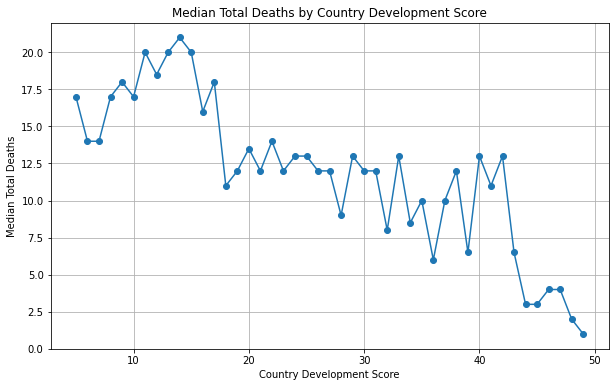

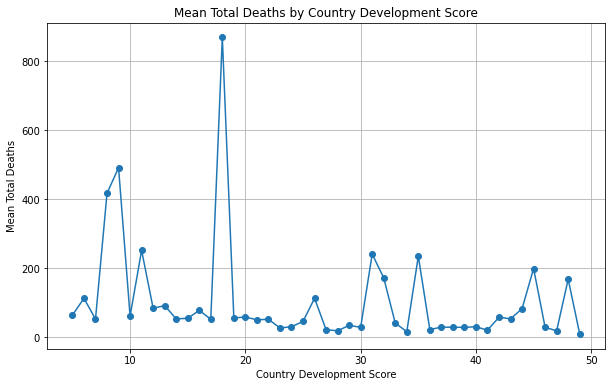

In [33]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df_test_1 contains your dataset

# Calculate mean Total Deaths for each value of country_developlment_score
median_deaths_by_score = df_test.groupby('country_devlopment_score')['Total Deaths'].median()

# Plot
plt.figure(figsize=(10, 6))
plt.plot(median_deaths_by_score.index, median_deaths_by_score.values, marker='o', linestyle='-')
plt.xlabel('Country Development Score')
plt.ylabel('Median Total Deaths')
plt.title('Median Total Deaths by Country Development Score')
plt.grid(True)
plt.show()

# Calculate mean Total Deaths for each value of country_developlment_score
mean_deaths_by_score = df_test.groupby('country_devlopment_score')['Total Deaths'].mean()

# Plot
plt.figure(figsize=(10, 6))
plt.plot(mean_deaths_by_score.index, mean_deaths_by_score.values, marker='o', linestyle='-')
plt.xlabel('Country Development Score')
plt.ylabel('Mean Total Deaths')
plt.title('Mean Total Deaths by Country Development Score')
plt.grid(True)
plt.show()

In [34]:
import plotly.graph_objs as go
import pandas as pd

# Assuming df_test_1 contains your dataset

# Calculate mean Total Deaths for each value of country_development_score
#median_deaths_by_score = df_test.groupby('country_development_score')['Total Deaths'].median()

# Plot
fig = go.Figure(data=go.Scatter(x=median_deaths_by_score.index, y=median_deaths_by_score.values, mode='lines+markers'))
fig.update_layout(
    title='Median Total Deaths by Country Development Score',
    xaxis=dict(tickmode='linear', tick0=0, dtick=10),  # Adjust the tick frequency as needed
    yaxis=dict(tickmode='linear', tick0=0, dtick=2.5),  # Adjust the tick frequency as needed
    xaxis_title='Country Development Score',
    yaxis_title='Median Total Deaths',
    showlegend=False,
    hovermode='x unified'
)
fig.show()

# Define the folder path where you want to save the HTML file
folder_path = "/Users/samharris/Desktop/Capstone/24Spr_-S-Harris-_-disasters-/Sample_Capstone/code/website/"

# Ensure that the folder exists
os.makedirs(folder_path, exist_ok=True)

# Define the file path
file_path = os.path.join(folder_path, 'median_total_deaths_by_dev_score.html')

# Save the figure as HTML file
fig.write_html(file_path)

# Calculate mean Total Deaths for each value of country_development_score
#mean_deaths_by_score = df_test.groupby('country_development_score')['Total Deaths'].mean()

# Plot
#fig = go.Figure(data=go.Scatter(x=mean_deaths_by_score.index, y=mean_deaths_by_score.values, mode='lines+markers'))
#fig.update_layout(
#    title='Mean Total Deaths by Country Development Score',
#   xaxis=dict(tickmode='linear', tick0=0, dtick=2),  # Adjust the tick frequency as needed
#   yaxis=dict(tickmode='linear', tick0=0, dtick=200),  # Adjust the tick frequency as needed
#   xaxis_title='Country Development Score',
#  yaxis_title='Mean Total Deaths',
#  showlegend=False,
#   hovermode='x unified'
#)
#fig.show()




In [35]:
import plotly.graph_objects as go
import plotly.io as pio

# Specify the full path where you want to save the image
file_path = "/Users/samharris/Desktop/"

# Specify the DPI (dots per inch) for higher resolution
dpi = 300

# Write the image using the kaleido engine with the desired DPI
#pio.write_image(fig, file_path + 'plot_high_dpi.png', engine='kaleido', scale=dpi/100)


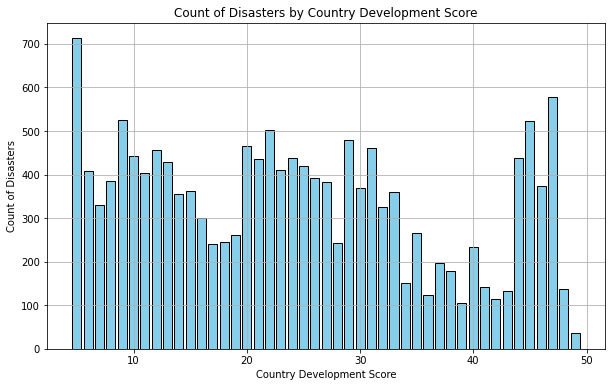

In [36]:
import pandas as pd
import matplotlib.pyplot as plt

# Calculate count of disasters for each value of country_development_score
disaster_count_by_score = df_test['country_devlopment_score'].value_counts()

# Plot
plt.figure(figsize=(10, 6))
plt.bar(disaster_count_by_score.index, disaster_count_by_score.values, color='skyblue', edgecolor='black')
plt.xlabel('Country Development Score')
plt.ylabel('Count of Disasters')
plt.title('Count of Disasters by Country Development Score')
plt.grid(True)
plt.show()


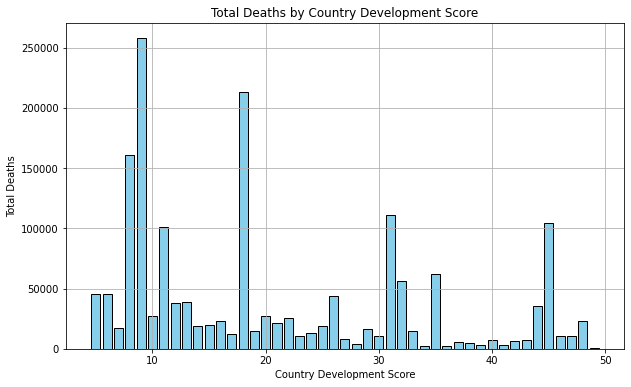

In [37]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df_test contains your dataset

# Calculate total deaths for each value of country_development_score
total_deaths_by_score = df_test.groupby('country_devlopment_score')['Total Deaths'].sum()

# Plot histogram of Total Deaths by country_development_score
plt.figure(figsize=(10, 6))
plt.bar(total_deaths_by_score.index, total_deaths_by_score.values, color='skyblue', edgecolor='black')
plt.xlabel('Country Development Score')
plt.ylabel('Total Deaths')
plt.title('Total Deaths by Country Development Score')
plt.grid(True)
plt.show()



In [38]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Assuming your data is in a DataFrame called 'df'
data = df[['gdp_per_cap', 'pop_den', 'i_mort', 'co2_emissions', 'electricity_percentage', 'life_expectancy']]

# Drop rows with missing values
data = data.dropna()

# Separate the index of the remaining data
indices = data.index

# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

# Apply PCA
pca = PCA()
pca.fit(scaled_data)

# Assuming 'pca' is your PCA object
eigenvalues = pca.explained_variance_
eigenvectors = pca.components_

print("Eigenvalues:")
print(eigenvalues)

print("\nEigenvectors:")
print(eigenvectors)


Eigenvalues:
[3.6249562  1.08753493 0.81707785 0.24896699 0.16543581 0.05647342]

Eigenvectors:
[[ 0.39033615 -0.01045069 -0.48170252  0.41853498  0.44907472  0.48851972]
 [-0.28372649  0.84397735 -0.14130777 -0.3266104   0.20003148  0.20136206]
 [ 0.58023147  0.52070372  0.27375748  0.38851674 -0.36681995 -0.17819591]
 [-0.47456527  0.11131523  0.2011051   0.64747271  0.41736876 -0.358519  ]
 [ 0.40045653 -0.04048042  0.52649751 -0.34553385  0.65550616 -0.10823265]
 [ 0.21187445  0.04930428 -0.59616168 -0.16909849  0.14098728 -0.74080891]]


In [39]:
df['Total Deaths'].sum()

1709748.0

In [40]:
import plotly.express as px
import pandas as pd

# Assuming df is your DataFrame with 'Subregion' and 'Total Deaths' columns

# Group by 'Subregion'
grouped = df.groupby('Subregion')

# Define a function to remove outliers within each group
def remove_outliers(group):
    Q1 = group['Total Deaths'].quantile(0.25)
    Q3 = group['Total Deaths'].quantile(0.75)
    IQR = Q3 - Q1
    return group[(group['Total Deaths'] > (Q1 - 1.5 * IQR)) & (group['Total Deaths'] < (Q3 + 1.5 * IQR))]

# Apply the function to each group and concatenate the results
df_filtered = grouped.apply(remove_outliers).reset_index(drop=True)

# Create the violin plot
fig = px.violin(df_filtered, x='Subregion', y='Total Deaths')

# Update layout
fig.update_layout(title='Violin Plot of Total Deaths by Subregion (Excluding Outliers)',
                  xaxis_title='Subregion',
                  yaxis_title='Total Deaths')

# Show the plot
fig.show()




In [41]:
import plotly.express as px
import pandas as pd

# Assuming df is your DataFrame with 'Subregion' and 'Total Deaths' columns

# Group by 'Subregion'
grouped = df.groupby('Subregion')

# Define a function to remove outliers within each group
def remove_outliers(group):
    Q1 = group['Total Deaths'].quantile(0.25)
    Q3 = group['Total Deaths'].quantile(0.75)
    IQR = Q3 - Q1
    return group[(group['Total Deaths'] > (Q1 - 1.5 * IQR)) & (group['Total Deaths'] < (Q3 + 1.5 * IQR))]

# Apply the function to each group and concatenate the results
df_filtered = grouped.apply(remove_outliers).reset_index(drop=True)

# Recalculate maximum 'Total Deaths' for each 'Subregion' after outliers have been removed
max_values = df_filtered.groupby('Subregion')['Total Deaths'].max()

# Sort the 'Subregion' categories by maximum values
sorted_subregions = max_values.sort_values(ascending=False).index

# Reorder the DataFrame based on sorted 'Subregion'
df['Subregion'] = pd.Categorical(df['Subregion'], categories=sorted_subregions, ordered=True)

# Group by 'Subregion' again to ensure the correct order for plotting
grouped_sorted = df.groupby('Subregion')

# Create the violin plot
fig = px.violin(df_filtered, x='Subregion', y='Total Deaths')

# Update layout
fig.update_layout(title='Violin Plot of Total Deaths by Subregion (Excluding Outliers)',
                  xaxis_title='Subregion',
                  yaxis_title='Total Deaths')

# Show the plot
fig.show()



/var/folders/lg/vpwp92v96rsbh9x3s5fyjd9w0000gn/T/ipykernel_34952/3873064170.py:29: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [42]:
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

def plot_violin_grouped_by_variable_no_outlier(data, gb_variable, variable):
    # Group the data by 'gb_variable' and calculate quartiles
    grouped_data = data.groupby(gb_variable)[variable]
    quartiles = grouped_data.quantile([0.25, 0.75]).unstack()
    
    # Calculate IQR and upper bound for whiskers
    quartiles['IQR'] = quartiles[0.75] - quartiles[0.25]
    quartiles['upper_whisker'] = quartiles[0.75] + 1.5 * quartiles['IQR']
    
    # Filter out outliers
    filtered_data = data[data[gb_variable].map(quartiles['upper_whisker']).ge(data[variable])]
    
    # Create violin plot without outliers
    fig = px.violin(filtered_data, x=gb_variable, y=variable, box=True, points=False)
    
    # Adjust the color and transparency of the violins
    for violin in fig.data:
        violin.fillcolor = 'skyblue'  # Light blue color
        violin.opacity = 0.7
    
    def get_variable_name(var):
        for name, value in globals().items():
            if value is var:
                return name
        return None
    
    # Define the title based on the region
    if get_variable_name(data) == "africa_df":
        title_1 = f'Violin plot of {variable} by African Subregions (without outliers)'
    elif get_variable_name(data) == "asia_df":
        title_1 = f'Violin plot of {variable} by Asian Subregions (without outliers)'
    elif get_variable_name(data) == "americas_df":
        title_1 = f'Violin plot of {variable} by American Subregions (without outliers)'
    else:
        title_1 = f'Violin plot of {variable} by {gb_variable} (without outliers)'
    
    # Update layout and styling
    fig.update_layout(showlegend=False,
                      title=title_1,
                      xaxis_title=gb_variable, yaxis_title=variable)
    fig.update_traces(line=dict(color='black', width=2))  # Violin lines
    
    # Show plot
    fig.show()

# Example usage
plot_violin_grouped_by_variable_no_outlier(df, 'Subregion', 'Total Deaths')


/var/folders/lg/vpwp92v96rsbh9x3s5fyjd9w0000gn/T/ipykernel_34952/2717516751.py:7: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [43]:
# Rescale Cost to be in millions
df.rename(columns={"Total Damage, Adjusted ('000 US$)": "Total Damage, Adjusted (millions US$)"}, inplace=True)

df["Total Damage, Adjusted (millions US$)"] = (df["Total Damage, Adjusted (millions US$)"] / 1000000)

In [44]:
import pandas as pd
import numpy as np
import plotly.express as px

def plot_violin_grouped_by_variable_no_outlier(data, gb_variable, variable):
    # Group the data by 'gb_variable' and calculate quartiles
    grouped_data = data.groupby(gb_variable)[variable]
    quartiles = grouped_data.quantile([0.25, 0.75]).unstack()
    
    # Calculate IQR and upper bound for whiskers
    quartiles['IQR'] = quartiles[0.75] - quartiles[0.25]
    quartiles['upper_whisker'] = quartiles[0.75] + 1.5 * quartiles['IQR']
    quartiles['lower_whisker'] = quartiles[0.25] - 1.5 * quartiles['IQR']
    
    # Filter out outliers
    filtered_data = data[
        np.asarray(data[gb_variable].map(quartiles['upper_whisker'])) >= data[variable]
    ]
    filtered_data = filtered_data[
        np.asarray(data[gb_variable].map(quartiles['lower_whisker'])) <= data[variable]
    ]
    
    # Calculate median for each group and sort the groups based on median
    maxs = filtered_data.groupby(gb_variable)[variable].max().sort_values(ascending=False)
    ordered_groups = maxs.index.tolist()
    
    # Create violin plot without outliers
    fig = px.violin(
        filtered_data, x=gb_variable, y=variable, box=True, points=False,
        category_orders={gb_variable: ordered_groups}
    )
    
    # Adjust the color and transparency of the violins
    for violin in fig.data:
        violin.fillcolor = 'skyblue'  # Light blue color
        violin.opacity = 0.7
    
    def get_variable_name(var):
        for name, value in globals().items():
            if value is var:
                return name
        return None

    
    if get_variable_name(data) == "africa_df":
        title_1 = f'Violin Plot of {variable} by African Subregions (without outliers)'

    elif get_variable_name(data) == "asia_df":
        title_1 = f'Violin Plot of {variable} by Asian Subregions (without outliers)'

    elif get_variable_name(data) == "americas_df":
        title_1 = f'Violin Plot of {variable} by American Subregions (without outliers)'
    else:
        title_1 = f'Violin Plot of {variable} by {gb_variable} (without outliers)'

    # Update layout and styling
    fig.update_layout(
        showlegend=False,
        title=title_1,
        xaxis_title=gb_variable,
        yaxis_title=variable
    )
    fig.update_traces(line=dict(color='black', width=2))  # Violin lines
    
    # Show plot
    fig.show()

    # Define the path to the folder where you want to save the HTML file
    folder_path = "/Users/samharris/Desktop/Capstone/24Spr_-S-Harris-_-disasters-/Sample_Capstone/code/website/"

    # Save the Plotly map to an HTML file in the specified folder
    file_path = folder_path + f"Violinplot_of_{variable}_by_{gb_variable}_(without_outliers)"

    if get_variable_name(data) == "africa_df":
        file_path = folder_path + f"Violinplot_of_{variable}_by_{gb_variable}(africa)_(without_outliers)"

    if get_variable_name(data) == "asia_df":
        file_path = folder_path + f"Violinplot_of_{variable}_by_{gb_variable}(asia)_(without_outliers)"

    if get_variable_name(data) == "americas_df":
        file_path = folder_path + f"Violinplot_of_{variable}_by_{gb_variable}(americas)_(without_outliers)"

    pio.write_html(fig, file_path)
    # Specify the full path where you want to save the image
    #file_path = "/Users/samharris/Desktop/"

    # Specify the DPI (dots per inch) for higher resolution
    #dpi = 300

    # Write the image using the kaleido engine with the desired DPI
    #pio.write_image(fig, file_path + 'plot_high_dpi.png', engine='kaleido', scale=dpi/100)

# Example usage
plot_violin_grouped_by_variable_no_outlier(df, 'Region', 'Total Deaths')
plot_violin_grouped_by_variable_no_outlier(df, 'Region', 'Total Affected')
plot_violin_grouped_by_variable_no_outlier(df, 'Region', "Total Damage, Adjusted (millions US$)")

/var/folders/lg/vpwp92v96rsbh9x3s5fyjd9w0000gn/T/ipykernel_34952/794626676.py:19: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



/var/folders/lg/vpwp92v96rsbh9x3s5fyjd9w0000gn/T/ipykernel_34952/794626676.py:19: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



/var/folders/lg/vpwp92v96rsbh9x3s5fyjd9w0000gn/T/ipykernel_34952/794626676.py:19: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



In [45]:
africa_df = df[df['Region']=='Africa']
plot_violin_grouped_by_variable_no_outlier(africa_df, 'Subregion', 'Total Deaths')

/var/folders/lg/vpwp92v96rsbh9x3s5fyjd9w0000gn/T/ipykernel_34952/794626676.py:7: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/lg/vpwp92v96rsbh9x3s5fyjd9w0000gn/T/ipykernel_34952/794626676.py:19: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/var/folders/lg/vpwp92v96rsbh9x3s5fyjd9w0000gn/T/ipykernel_34952/794626676.py:24: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [46]:
asia_df = df[df['Region']=='Asia']
plot_violin_grouped_by_variable_no_outlier(asia_df, 'Subregion', 'Total Deaths')

/var/folders/lg/vpwp92v96rsbh9x3s5fyjd9w0000gn/T/ipykernel_34952/794626676.py:7: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/lg/vpwp92v96rsbh9x3s5fyjd9w0000gn/T/ipykernel_34952/794626676.py:19: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/var/folders/lg/vpwp92v96rsbh9x3s5fyjd9w0000gn/T/ipykernel_34952/794626676.py:24: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [47]:
americas_df = df[df['Region']=='Americas']
plot_violin_grouped_by_variable_no_outlier(americas_df, 'Subregion', 'Total Deaths')

/var/folders/lg/vpwp92v96rsbh9x3s5fyjd9w0000gn/T/ipykernel_34952/794626676.py:7: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/lg/vpwp92v96rsbh9x3s5fyjd9w0000gn/T/ipykernel_34952/794626676.py:19: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/var/folders/lg/vpwp92v96rsbh9x3s5fyjd9w0000gn/T/ipykernel_34952/794626676.py:24: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [48]:
plot_violin_grouped_by_variable_no_outlier(df, 'Subregion', 'Total Deaths')


/var/folders/lg/vpwp92v96rsbh9x3s5fyjd9w0000gn/T/ipykernel_34952/794626676.py:7: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/lg/vpwp92v96rsbh9x3s5fyjd9w0000gn/T/ipykernel_34952/794626676.py:19: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/var/folders/lg/vpwp92v96rsbh9x3s5fyjd9w0000gn/T/ipykernel_34952/794626676.py:24: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [49]:
result_df2[result_df2['Country']=='United States of America']

,Country,ISO,Disaster Type,Total Deaths,Total Affected,scaled_deaths,scaled_affected,Impact
1772,United States of America,USA,Air,713.0,261.0,3.565,0.261,2.73900
1773,United States of America,USA,Chemical spill,0.0,169.0,0.000,0.169,0.04225
1774,United States of America,USA,Collapse (Miscellaneous),151.0,334.0,0.755,0.334,0.64975
1775,United States of America,USA,Drought,181.0,0.0,0.905,0.000,0.67875
1776,United States of America,USA,Earthquake,6.0,35528.0,0.030,35.528,8.90450
1777,United States of America,USA,Epidemic,214.0,3653.0,1.070,3.653,1.71575
1778,United States of America,USA,Explosion (Industrial),146.0,999.0,0.730,0.999,0.79725
1779,United States of America,USA,Explosion (Miscellaneous),20.0,357.0,0.100,0.357,0.16425
1780,United States of America,USA,Extreme temperature,825.0,56.0,4.125,0.056,3.10775
1781,United States of America,USA,Fire (Miscellaneous),222.0,894.0,1.110,0.894,1.05600


In [50]:
import plotly.graph_objects as go
import plotly.io as pio

#plot_violin_grouped_by_variable_no_outlier(df, 'Region', 'Total Deaths')